In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import s3fs
import math

In [2]:
g = 9.80665
R_d = 287.052874
temp_grad = 0.0065
def extrapolate_temp(pressure_level, temp_surf, pressure_surf, geopotential_surf):
    if geopotential_surf / g < 2000:
        gamma = temp_grad
    else:
        x = temp_surf + temp_grad * geopotential_surf / g
        if geopotential_surf / g > 2500:
            t0 = min(x, 298)
        else:
            t0 = x + (min(x, 298) - x) / 500 * (geopotential_surf / g - 2000)
        gamma = g / geopotential_surf * max(t0 - temp_surf, 0)
    y = -gamma * R_d / g * math.log(pressure_surf / pressure_level)
    return temp_surf * (1 + y + y**2/2 + y**3/6)

In [3]:
def get_temp_surf(temp_bottom, pressure_bottom, pressure_surf):
    return temp_bottom + temp_grad * R_d / g * (pressure_surf / pressure_bottom - 1) * temp_bottom

In [4]:
fs = s3fs.S3FileSystem()
dsep = xr.open_dataset(fs.open('interns-shared/users/ddu1/ERA5/ERA5-pressure-level.nc'))
dsev = xr.open_dataset(fs.open('interns-shared/users/ddu1/ERA5/ERA5-model-level.nc'))
dses = xr.open_dataset(fs.open('interns-shared/users/ddu1/ERA5/ERA5-surface.nc'))

In [5]:
lat, lon = -90, -180
xe, ye = int((90-lat)/0.25), int((lon if lon >= 0 else lon+360) / 0.25)

pressure_surf = dses['sp'][0, xe, ye]/100
for i, p in reversed(list(enumerate(dsep.level))):
    if p <= pressure_surf:
        bottom_pressure_idx = i
        break

extrapolated_temps = xr.DataArray(
    data=[
        extrapolate_temp(
            pressure_level=p,
            
            temp_surf=dses['t2m'][0, xe, ye].values,
            # temp_surf=dsev['t'][0, -1, xe, ye].values,
            # temp_surf=dsep['t'][0, bottom_pressure_idx, xe, ye].values,
            # temp_surf=get_temp_surf(
            #     temp_bottom=dsep['t'][0, bottom_pressure_idx, xe, ye],
            #     pressure_bottom=dsep.level[bottom_pressure_idx],
            #     pressure_surf=pressure_surf
            # ),
            
            pressure_surf=pressure_surf,
            # pressure_surf=dsep.level[bottom_pressure_idx].values,
            
            geopotential_surf=dses['z'][0, xe, ye].values,
            # geopotential_surf=dsep['z'][0, bottom_pressure_idx, xe, ye].values,
        )
        for p in dsep.level
    ],
    dims='level',
    coords={'level': dsep.level}
)

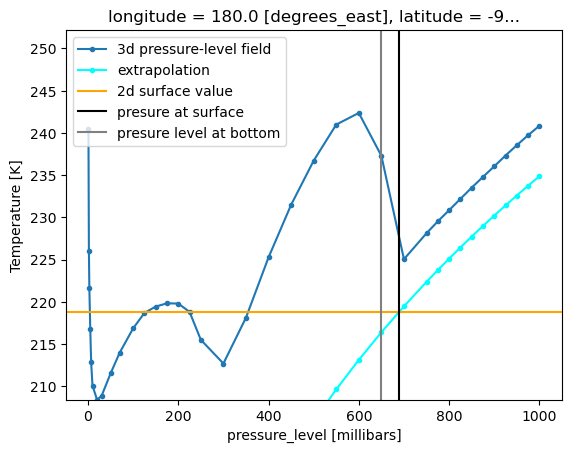

In [6]:
fig, ax = plt.subplots()
dsep['t'][0, :, xe, ye].plot(ax=ax, marker='.', label='3d pressure-level field')
ax.plot(dsep.level, extrapolated_temps, marker='.', c='cyan', label='extrapolation')
ax.axhline(dses['t2m'][0, xe, ye], c='orange', label='2d surface value')
ax.axvline(dses['sp'][0, xe, ye]/100, c='k', label='presure at surface')
ax.axvline(dsep.level[bottom_pressure_idx], c='gray', label='presure level at bottom')
ax.set_ylim(bottom=dsep['t'][0, :, xe, ye].min())
ax.legend()